In [0]:
import os
import keras
from keras.preprocessing.text import Tokenizer
import keras.preprocessing.text
from keras.models import Model
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding,SpatialDropout1D,Bidirectional,TimeDistributed, MaxPooling1D, Conv1D
from keras.layers import BatchNormalization,Flatten,Concatenate
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import TensorBoard
from time import time
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.nan)

%matplotlib inline

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Read Files

In [0]:
# Read files and stores in list
train_X = [line.rstrip() for line in open('drive/My Drive/datasets/xtrain_obfuscated.txt')]
train_Y = [line.rstrip() for line in open('drive/My Drive/datasets/ytrain.txt')]
test_X = [line.rstrip() for line in open('drive/My Drive/datasets/xtest_obfuscated.txt')]

# train_X = [line.rstrip() for line in open('xtrain_obfuscated.txt')]
# train_Y = [line.rstrip() for line in open('ytrain.txt')]
# test_X = [line.rstrip() for line in open('xtest_obfuscated.txt')]

In [5]:
len(train_X),len(train_Y),len(test_X)

(32513, 32513, 3000)

#### One-hot Encoding of Output Classes


In [0]:
encoder = LabelBinarizer()
encoder.fit(train_Y)
y_train = encoder.transform(train_Y)

In [9]:
y_train[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [0]:
#print("Mean length",text_lengths.mean())

In [0]:
# Split sequence to characters
#" ".join(train_X[0])
# sample
# for i in range(len(train_X[0:5])):
#     train_X[i] = " ".join(train_X[i])
    
# full data
for i in range(len(train_X)):
    train_X[i] = " ".join(train_X[i])
    
for i in range(len(test_X)):
    test_X[i] = " ".join(test_X[i])   
#keras.preprocessing.text.text_to_word_sequence(train_X[0], lower=True, split=" ")

In [12]:
test_X[0]

't v l e t w g z k r q v u h t w a m u l u h p k s k p m p m i w t v u h a m q v m v i w l r v i k q u h t w a m u l u h q g v i p m m v u l k r i w p m q v t w l e u h a m q v m v i w l r v i k q u h t w a m u l u h q g q v q v t w v i e z l e m v x e u h a m q v m v i w l r v i k q u h t w a m u l u h p k s k v i e n i w l r v i k q u h q v m v u h q g p m p m i w l e t w u l e n o k u h x e p m u h t w i w u l u l e n t v u h t w a m u l u h v i m v u h s k t w l e m v e z s k e n u h t w t v u h u l q v k r e z u h a m y p m v a m d f u h u l e n a m g u u h r a s k v i p m y p t w q v u h t w a m u l u h x e p m u h v i m v e n u l g z e n y p u h e n u h s a t v u h v i p m d f u h q g l e t w s k l e p m u h u l q v l e m v x e u h t w a m u l u h x e p m u h t w i w u l u l e n t v u h e n u h q v m v u h p m p m i w l e t w u l e n o k'

In [28]:
#maxlen = 1000

#Trial 2 - cut lenght
maxlen = 453
vocab_size = 26
t = Tokenizer(num_words=26)

# Fit on docs
t.fit_on_texts(train_X)

# Vectorise each test documents based on dictionary 
index_list = t.texts_to_sequences(train_X)

# Pad Zeros
training_X = pad_sequences(index_list, maxlen=maxlen)
print(training_X.shape)

# Vectorise each test documents based on dictionary 
index_list_test = t.texts_to_sequences(test_X)
test_X_encoded = pad_sequences(index_list_test, maxlen=maxlen)
print(test_X_encoded.shape)

(32513, 453)
(3000, 453)


In [33]:
## Sample Training Example 
print(training_X[0:3])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15
  11  8  7 11  3  1  6  1  2 13 17  1  6 11  3  6 16  3  4  5 18  1  2 13
   4 12 16 10  3  6  5  8  7  1  6 23  9  8  7 15 12  1  2  6  5  3  4  8
   7 11  3  1  6  1  2  9  7  9  7  5 14  1  2  6 16  4  9  3  4 13  4 12
  16  1  2  1  6  5 14 11  3  1  6  1  2 13 17 13  4  8  7  4  9  3  4  9
   7  1  2  8  7 11  3  1  6  1  2  1  6 13  4 12 16  5 14 11  3 23  9  8
   7  1  2  4  9 10  3 10  3 13  4  1  2 15 12  9  7 12 16 10  3 19 20  1
   2  6 16  4  9  3  4 15 12  4  9 12 16 10  3 13  4  1  2 15 12  3  4 17
  18  5 14  6  5  1  2 13  4  3  4 11  3  1  6  1  2  1  6  5 14 11  3  1
   6  1  2 13  4  6  5  8  7  8  7  4  9 10  3 10  3 17 18  6  5  5 14 11
   3  1  2  8  7 11  3  1  6  1  2  8  7  6  5  8  7 19 20  1  2  9  7 12
  16 22  5  6  5  5 14  8  7 22  5  1  2 10  3 13  4  1  2  8  7  9  7  3
   4 11  3 19 20  1  2 10 12  5 18  8 

#### Training Output

In [14]:
train_Y = np.array(train_Y)
train_Y = train_Y.astype(int)
print(train_Y[0:5])

[7 3 8 3 4]


#### Neural Network

In [15]:
## CNN + LSTM
#n_most_common_words = 30
vocab_size = 26
input_seqlen = 453

embedding_size = 15

# Convolution
kernel_size = [5,5]
filters = [64,32]
pool_size = [3]




model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=input_seqlen))
model.add(BatchNormalization())
model.add(Conv1D(filters[0],
                 kernel_size[0],
                 padding='valid',
                 activation='relu',
                 strides=1))
#model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=pool_size))

model.add(Conv1D(filters[1],
                 kernel_size[1],
                 padding='valid',
                 activation='relu',
                 strides=1))
#model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=pool_size))

model.add(Dropout(0.5))
model.add(LSTM(100))

model.add(Dense(500))
model.add(BatchNormalization())
model.add(Dense(12))
model.add(BatchNormalization())

model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 453, 15)           390       
_________________________________________________________________
batch_normalization_1 (Batch (None, 453, 15)           60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 449, 64)           4864      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 149, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 145, 32)           10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 32)            0         
__________

In [18]:
#history = model.fit(training_X,y_train, epochs=250, batch_size=128,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=10, min_delta=0.0001)])
history = model.fit(training_X,y_train, epochs=200, batch_size=128,validation_split=0.2)

Train on 26010 samples, validate on 6503 samples
Epoch 1/200
26010/26010 [==============================] - 33s 1ms/step - loss: 2.3270 - acc: 0.1882 - val_loss: 2.6154 - val_acc: 0.1539
Epoch 2/200
26010/26010 [==============================] - 32s 1ms/step - loss: 1.9573 - acc: 0.3319 - val_loss: 1.7026 - val_acc: 0.4078
Epoch 3/200
26010/26010 [==============================] - 32s 1ms/step - loss: 1.6489 - acc: 0.4443 - val_loss: 1.6798 - val_acc: 0.4269
Epoch 4/200
26010/26010 [==============================] - 32s 1ms/step - loss: 1.4857 - acc: 0.5013 - val_loss: 1.4206 - val_acc: 0.5155
Epoch 5/200
26010/26010 [==============================] - 32s 1ms/step - loss: 1.3864 - acc: 0.5318 - val_loss: 1.4560 - val_acc: 0.5116
Epoch 6/200
26010/26010 [==============================] - 32s 1ms/step - loss: 1.3283 - acc: 0.5498 - val_loss: 1.3865 - val_acc: 0.5201
Epoch 7/200
26010/26010 [==============================] - 32s 1ms/step - loss: 1.2754 - acc: 0.5611 - val_loss: 1.4449 - v

### Plot Accuracy,Loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


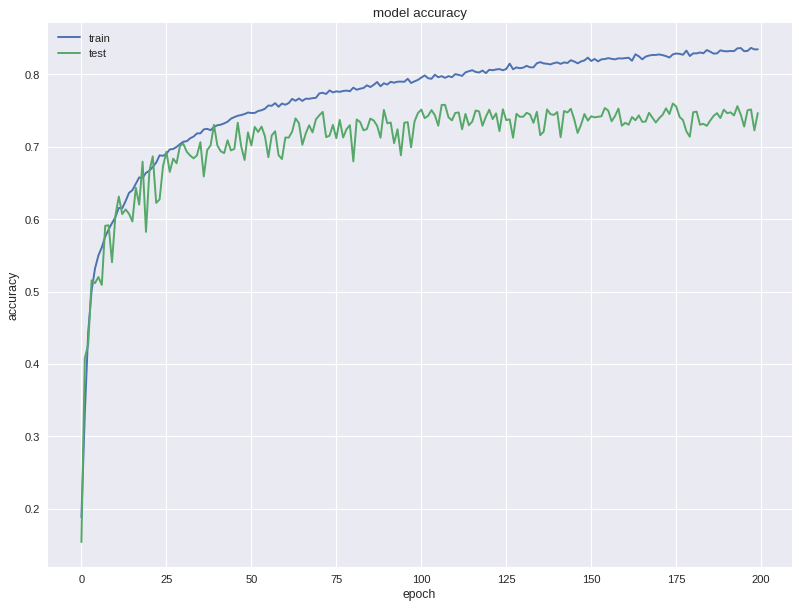

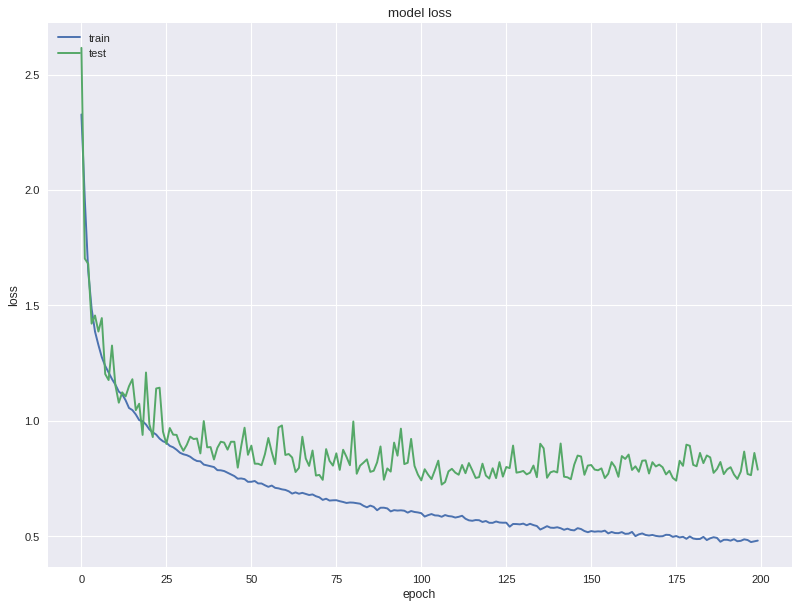

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

In [0]:
# Save Model as JSON
model_json = model.to_json()
with open("model_v14.json", "w") as json_file:
    json_file.write(model_json)

### Predicted File

In [0]:
## Perform predictions using prepared NN model on encoded test dataset
## Save predictions in ytest.txt file

#label_list = []
num_test_cases = len(test_X)   # test with 100
text_labels = encoder.classes_

with open('ytest_v14.txt', 'w') as f:
    for i in range(num_test_cases):    
      prediction = model.predict(np.array([test_X_encoded[i]]))
      label = text_labels[np.argmax(prediction[0])]
      #label_list.append(label)
      f.write("%s\n" % label)
    
#print('Sample 100 predictions :',label_list)

In [0]:
# # Download File from Collaboratory
# from google.colab import files
# files.download('ytest_v14.txt')